In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchaudio
from torchaudio import transforms
from torchaudio.transforms import MelSpectrogram

from torch.utils.data import DataLoader, random_split, Dataset
from tqdm import tqdm


import matplotlib.pyplot as plt
from google.colab import drive
import os

In [2]:
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
print(os.listdir(os.path.join("drive", "MyDrive", "Pokedex")))

['Pokedex.v7i.folder.zip', 'models', 'Pokedex.v9i.folder.zip', 'pokedex', 'recordings.zip', 'audio_rec', 'recordings2.zip', 'audio', 'PokeAudio.ipynb']


In [5]:
import zipfile

data_path = os.path.join("drive", "MyDrive", "Pokedex")
# Path to the zip file and where to extract
zip_path = os.path.join(data_path, 'recordings2.zip')
extract_to = os.path.join(data_path, 'audio')

# Check if it already exists
if not os.path.exists(extract_to):
  # Extract the zip file
  print(f'Extracting {zip_path} to {extract_to}')
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_to)
else:
  print(f'Archive already extracted to {extract_to}')

Archive already extracted to drive/MyDrive/Pokedex/audio


In [6]:
class AudioDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None, sample_rate=16000, max_len=50):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))
        self.filepaths = []
        self.labels = []
        self.sample_rate = sample_rate
        self.transform = transform
        self.target_transform = target_transform
        self.max_len = max_len

        for label, cls in enumerate(self.classes):
            cls_folder = os.path.join(root_dir, cls)
            for file in os.listdir(cls_folder):
                if file.endswith('.wav'):
                    self.filepaths.append(os.path.join(cls_folder, file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        waveform, sr = torchaudio.load(self.filepaths[idx])
        if sr != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sr, self.sample_rate)

        if self.transform:
            waveform = self.transform(waveform)

        # Pad the Mel Spectrogram to a fixed length
        if waveform.shape[-1] < self.max_len:
            padding = self.max_len - waveform.shape[-1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))
        elif waveform.shape[-1] > self.max_len:
            waveform = waveform[:, :, :self.max_len]

        return waveform, self.labels[idx]

In [7]:
print(os.listdir(os.path.join("drive", "MyDrive", "Pokedex", "audio", "recordings")))

['magikarp', 'gengar', 'bulbosaur', 'squirtle', 'pikachu', 'charmander', 'psyduck', 'mew']


In [8]:
transform = torch.nn.Sequential(
    MelSpectrogram(sample_rate=16000, n_mels=64),
    torchaudio.transforms.AmplitudeToDB()
)

In [9]:
import random
path = os.path.join("drive", "MyDrive", "Pokedex", "audio", "recordings")

# get the entire dataset using your class you made in step 3
train_fullset = AudioDataset(path, transform=transform)
# make a list of indices of the dataset use range or np.arange
fullset_indices= list(range(len(train_fullset)))
random.shuffle(fullset_indices)
# split the indices into 80% trainset and 20% testset
# this makes two lists of indices
train_indices = fullset_indices[:int(len(fullset_indices)*0.7)]
val_indices = fullset_indices[int(len(fullset_indices)*0.7):int(len(fullset_indices)*.9)]
test_indices = fullset_indices[int(len(fullset_indices)*0.9):]


# Use Subset and indices to get two new subsets
trainset = torch.utils.data.Subset(train_fullset, train_indices)
valset = torch.utils.data.Subset(train_fullset, val_indices)
testset = torch.utils.data.Subset(train_fullset, test_indices)

In [10]:
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, drop_last=True)
valloader = DataLoader(valset, batch_size=32, shuffle=False, drop_last=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False, drop_last=True)

In [11]:
audio, label = next(iter(trainloader))
print(audio.shape)
print(label.shape)

torch.Size([32, 1, 64, 50])
torch.Size([32])


In [12]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.batchNorm1 = nn.BatchNorm2d(16)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)


    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.batchNorm2 = nn.BatchNorm2d(32)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.batchNorm3 = nn.BatchNorm2d(64)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.batchNorm4 = nn.BatchNorm2d(128)
    # self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)


    self.fc1 = nn.Linear(128*8*6, 256)
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(256, 8)
  def forward(self, x):
    x = torch.relu(self.batchNorm1(self.conv1(x)))

    x = self.pool1(x)

    x = torch.relu(self.batchNorm2(self.conv2(x)))
    x = self.pool2(x)

    x = torch.relu(self.batchNorm3(self.conv3(x)))
    x = self.pool3(x)

    x = torch.relu(self.batchNorm4(self.conv4(x)))
    # x = self.pool4(x)



    # print(x.shape)

    x = x.view(-1, 128*8*6)

    x = torch.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x


In [20]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):  # x: (B, C, H, W)
        # Reshape input from (B, C, H, W) to (B, W, H*C) for LSTM
        # x = x.squeeze(1)
        x = x.reshape(-1,50, 64)

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        output, _ = self.lstm(x, (h0, c0))

        out = output[:, -1, :]
        out = F.relu(self.fc1(out))  # Use the hidden state of the last layer for the fully connected layer
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name ="Model"):
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  model.train()

  print(f'--- Training {model_name} for {num_epochs} epochs ---')

  for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    acc_val = 0
    total_val = 0
    running_val_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    model.train()

    for data, target in pbar:
      data, target = data.to(device), target.to(device)

      # Step 1: zero the gradient
      optimizer.zero_grad()

      # Step 2: forward pass
      output = model(data)

      # Step 3: Calculate the loss
      loss = criterion(output, target)

      # Step 4: Backward pass
      loss.backward()

      # Step 5: Update the weifhts
      optimizer.step()

      running_loss+= loss.item()
      _, predicted = torch.max(output.data, 1)
      total +=target.size(0)
      correct += (predicted == target).sum().item()

      pbar.set_postfix({'Loss': f'{running_loss/len(train_loader)}', 'Accuracy': f'{100*correct/total}'})

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    model.eval()
    with torch.no_grad():
      for data, target in tqdm(valloader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        val_loss = criterion(output, target)
        running_val_loss += val_loss.item()

        _, predicted = torch.max(output.data, 1)
        total_val += target.size(0)
        acc_val += (predicted == target).sum().item()
    val_losses.append(running_val_loss / len(val_loader))
    val_accuracy = 100 * acc_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Validation Accuracy {val_accuracy}")

  print(f'---Finished training {model_name}---')
  return train_losses, train_accuracies, val_losses, val_accuracies

In [15]:
def evaulate_model(model, test_loader):
  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data) # Forward pass
      _, predicted = torch.max(output, 1)
      total+= target.size(0)
      correct += (predicted == target).sum().item()

  return 100 * correct / total


In [16]:


from torchvision.models import vgg11_bn, VGG11_BN_Weights

test_model = vgg11_bn(weights=VGG11_BN_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:06<00:00, 85.7MB/s]


In [17]:
class Net(nn.Module):
  def __init__(self, num_classes=100):
    super(Net, self).__init__()
    self.base_model = vgg11_bn(weights=VGG11_BN_Weights.IMAGENET1K_V1)

    # Freeze featurizer
    for param in self.base_model.parameters():
      param.requires_grad = False

    # Replace the classifier
    self.base_model.classifier = nn.Sequential(
        nn.Linear(25088, 1280, bias=True),
        nn.ReLU(inplace=True),
        nn.Dropout(.3),
        nn.Linear(1280,8, bias=True)
    )

    for params in self.base_model.classifier.parameters():
      params.requires_grad = True

  def forward(self,x):
    x = x.repeat(3,1,1)
    outputs = self.base_model(x)
    return outputs

In [33]:
model_cnn = LSTMClassifier(input_size=64, hidden_size=512, num_layers=2, num_classes=8).to(device)
# model_cnn = SimpleCNN().to(device)
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=.001)
criterion = nn.CrossEntropyLoss()
print(model_cnn)

LSTMClassifier(
  (lstm): LSTM(64, 512, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=8, bias=True)
)


In [34]:
cnn_losses, cnn_accuracies, val_losses, val_accuracies = train_model(model_cnn, trainloader, valloader,criterion, optimizer_cnn, num_epochs=50, model_name="CNN on PokeDex")

--- Training CNN on PokeDex for 50 epochs ---


100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


Validation Accuracy 9.375


100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


Validation Accuracy 14.285714285714286


100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Validation Accuracy 13.839285714285714


100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


Validation Accuracy 18.303571428571427


100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


Validation Accuracy 25.446428571428573


100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


Validation Accuracy 21.875


100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


Validation Accuracy 24.107142857142858


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Validation Accuracy 23.660714285714285


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


Validation Accuracy 31.25


100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Validation Accuracy 23.660714285714285


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


Validation Accuracy 28.571428571428573


100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Validation Accuracy 29.464285714285715


100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


Validation Accuracy 29.017857142857142


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


Validation Accuracy 29.910714285714285


100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Validation Accuracy 36.160714285714285


100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


Validation Accuracy 32.589285714285715


100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


Validation Accuracy 35.714285714285715


100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


Validation Accuracy 32.589285714285715


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Validation Accuracy 33.482142857142854


100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


Validation Accuracy 31.696428571428573


100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


Validation Accuracy 37.94642857142857


100%|██████████| 7/7 [00:04<00:00,  1.57it/s]


Validation Accuracy 35.714285714285715


100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


Validation Accuracy 39.285714285714285


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Validation Accuracy 39.285714285714285


100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


Validation Accuracy 43.30357142857143


100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


Validation Accuracy 40.17857142857143


100%|██████████| 7/7 [00:04<00:00,  1.57it/s]


Validation Accuracy 41.07142857142857


100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


Validation Accuracy 35.714285714285715


100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Validation Accuracy 40.625


100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


Validation Accuracy 38.392857142857146


100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


Validation Accuracy 40.625


100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Validation Accuracy 45.982142857142854


100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


Validation Accuracy 37.05357142857143


100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


Validation Accuracy 42.857142857142854


100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


Validation Accuracy 43.30357142857143


100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


Validation Accuracy 46.42857142857143


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Validation Accuracy 43.75


100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


Validation Accuracy 44.19642857142857


100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Validation Accuracy 41.964285714285715


100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


Validation Accuracy 45.982142857142854


100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


Validation Accuracy 40.625


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Validation Accuracy 44.642857142857146


100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


Validation Accuracy 43.75


100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


Validation Accuracy 43.30357142857143


100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


Validation Accuracy 45.089285714285715


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Validation Accuracy 43.30357142857143


100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


Validation Accuracy 44.19642857142857


100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


Validation Accuracy 45.982142857142854


100%|██████████| 7/7 [00:04<00:00,  1.57it/s]


Validation Accuracy 49.107142857142854


100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

Validation Accuracy 45.982142857142854
---Finished training CNN on PokeDex---


In [35]:
print(f'Test Accuracy: {evaulate_model(model_cnn, testloader)}')

Test Accuracy: 47.916666666666664


In [ ]:
save_to = os.path.join('drive', 'MyDrive', 'Pokedex', 'models', "poke_audio_model_v1.pth")

# save weights
torch.save(model_cnn.state_dict(), save_to)

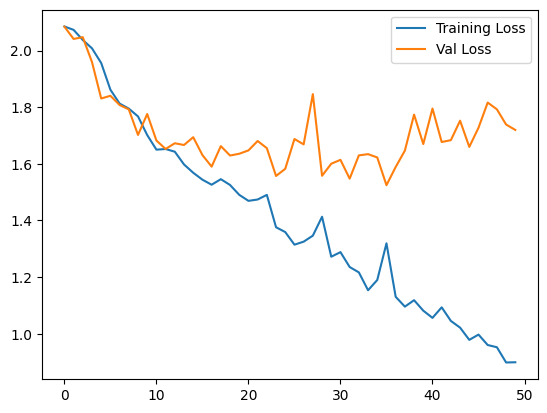

In [36]:
plt.plot(cnn_losses, label="Training Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.show()

In [ ]:
# Get one item from the trainset
mel_spectrogram, label = trainset[2]

# The mel_spectrogram is likely of shape (C, H, W), where C is 1 for grayscale images (mel_spectrograms)
# and H and W are height and width. We need to remove the channel dimension for plotting.
mel_spectrogram = mel_spectrogram.squeeze(0)

# Plot the Mel Spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram.log2(), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram of a training sample')
plt.xlabel('Time Frame')
plt.ylabel('Mel Filter Bank')
plt.tight_layout()
plt.show()